In [17]:
import numpy as np
from scipy.optimize import golden, newton, linesearch
import matplotlib.pyplot as plt
from jax import numpy as jnp
from jax import grad

# One-Dimensional Optimization

<hr>

**Lab Objective:** Most mathematical optimization problems involve estimating the minimizer(s) of
a scalar-valued function. Many algorithms for optimizing functions with a high-dimensional domain
depend on routines for optimizing functions of a single variable. There are many techniques for
optimization in one dimension, each with varying degrees of precision and speed. In this lab, I
implement the golden section search method, Newton’s method, and the secant method, then apply
them to the backtracking problem.

## Golden Section Search

Golden Section Search is an optimization method used to find the maximum or minimum of a unimodal function by successively narrowing the range of possible values. The technique is based on the concept of the "golden ratio," which is the number $\frac{1 + \sqrt{5}}{2}$. The algorithm works by dividing the interval into two parts in such a way that the ratio of the smaller interval to the larger interval is equal to the golden ratio. The value of the function is then evaluated at the midpoint of the larger interval, and the process is repeated with the new interval until the maximum or minimum value is found to a desired level of accuracy.

In [18]:
def golden_section(f, a, b, tol=1e-5, maxiter=100):
    """Use the golden section search to minimize the unimodal function f.

    Parameters:
        f (function): A unimodal, scalar-valued function on [a,b].
        a (float): Left bound of the domain.
        b (float): Right bound of the domain.
        tol (float): The stopping tolerance.
        maxiter (int): The maximum number of iterations to compute.

    Returns:
        (float): The approximate minimizer of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """

    # Set the initial minimizer approximation as the interval midpoint
    x0 = (a+b) / 2 
    ϕ = (1+np.sqrt(5)) / 2
    convergence = False

    # Iterate only maxiter times at most
    for i in range(1, maxiter+1):
        c = (b-a) / ϕ
        a_tilda = b - c
        b_tilda = a + c

        # Get new boundaries for the search interval
        if f(a_tilda) <= f(b_tilda):
            b = b_tilda
        else:
            a = a_tilda
        
        # Set the minimizer approximation as the interval midpoint
        x1 = (a+b) / 2

        if np.abs(x0 - x1) < tol:
            # Stop iterating if the approximation stops changing enough
            convergence = True
            break
        
        # Update the minimizer approximation
        x0 = x1
    
    return x1, convergence, i

I will test my function by minimizing $f(x) = e
x − 4x$ on the interval $[0, 3]$, then plotting the
function and the computed minimizer together. I also compare my results to SciPy’s golden section search, *scipy.optimize.golden()*.

In [41]:
def plot(range, f, x, y, my_label, scipy_label, title, func_label):
    """Plot the function and the minimizer approximations.

    Parameters:
        domain (np.ndarray): The domain of the function.
        f (function): The function to plot.
        x (np.ndarray): The minimizer approximations.
        y (np.ndarray): The function values at the minimizer approximations.
        my_label (str): The label for the minimizer approximation from my algorithm.
        scipy_label (str): The label for the minimizer approximation from scipy.
        title (str): The title of the plot.
    """
    domain = np.linspace(range[0], range[1], 1000)

    plt.plot(domain, f(domain), label=func_label)
    plt.plot(x[0], x[1], "o", label=my_label)
    plt.plot(y[0], y[1], "o", label=scipy_label)
    plt.title(title, size=15)
    plt.xlabel('x axis')
    plt.ylabel('y axis')
    plt.legend()
    plt.show()

My Minimizer:  1.386290222451367
SciPy Minimizer:  1.3862578679031485


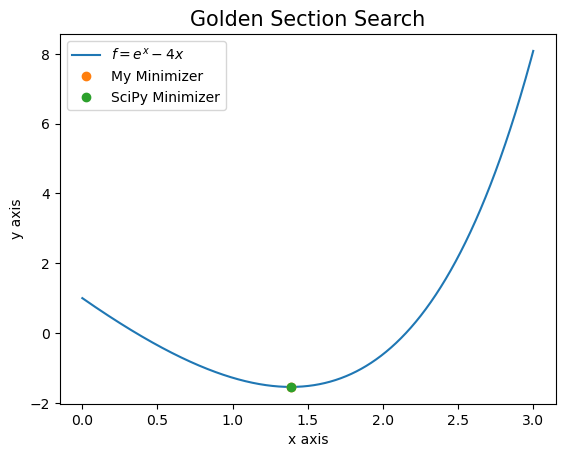

In [42]:
# Define function to minimize
f = lambda x: np.exp(x) - 4*x

# Perform the golden section searches
my_min = golden_section(f, 0, 3)
scipy_min = golden(f, brack=(0,3), tol=.001)

print("My Minimizer: ", my_min[0])
print("SciPy Minimizer: ", scipy_min)

# Plot the function and the minimazer approximations
plot((0,3), f, 
    [my_min[0], f(my_min[0])], 
    [scipy_min, f(scipy_min)], 
    "My Minimizer", "SciPy Minimizer", 
    "Golden Section Search", "$f = e^x - 4x$")


## Newton's Method

Newton's method, also known as Newton-Raphson method, is a root-finding algorithm that uses iterative refinement to find the roots (i.e. the zeros) of a real-valued function. Given an initial guess, it linearizes the function at that point and finds the root of the linear approximation, which is used as a better guess for the root of the original function. The process is repeated until a satisfactory level of accuracy is reached.

The algorithm is based on the observation that if a function $f(x)$ has a root at $x_k$, then a straight line tangent to the graph of the function at $x_k$ will intersect the $x$-axis at $x_k$. Thus, the equation of this tangent line can be used to approximate the value of the root, which can then be refined by repeating the process.

The formula for Newton's method is given by $x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}$. The first-order necessary conditions from elementary calculus state that if $f$ is differentiable, then its derivative evaluates to zero at each of its local minima and maxima. Therefore using Newton’s method to find the zeros of $f'$ is a way to identify potential minima or maxima of $f$. Specifically, starting with an initial guess $x_k$, let $x_{k+1} = x_k - \frac{f'(x_k)}{f''(x_k)}$.

In [21]:
def newton1d(df, d2f, x0, tol=1e-5, maxiter=100):
    """Use Newton's method to minimize a function f:R->R.

    Parameters:
        df (function): The first derivative of f.
        d2f (function): The second derivative of f.
        x0 (float): An initial guess for the minimizer of f.
        tol (float): The stopping tolerance.
        maxiter (int): The maximum number of iterations to compute.

    Returns:
        (float): The approximate minimizer of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    convergence = False

    for k in range(1, maxiter+1):
        x1 = x0 - (df(x0) / d2f(x0))  # Compute the next iteration.

        if abs(x1 - x0) < tol: # Check for convergence.
            convergence = True
            break # Upon convergence, stop iterating.

        x0 = x1 # else, continue iterating

    return x1, convergence, k 

To test my function, I minimize $f(x) = x^2 + \sin{(5x)}$ with an initial guess of $x_0 = 0$. I also compare my results to *scipy.optimize.newton()*, which implements the root-finding version of Newton’s method.

My Minimizer:  -1.4473142236328096
SciPy Minimizer:  -1.4473142236328096


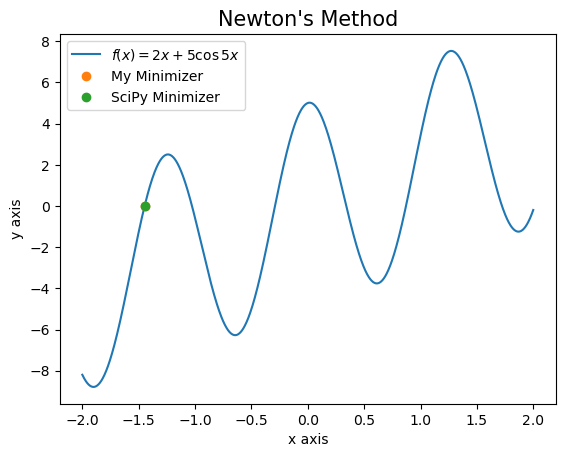

In [49]:
# Define functions to minimize
df = lambda x : 2*x + 5*np.cos(5*x)
d2f = lambda x : 2 - 25*np.sin(5*x)

# Perform the Newton's method searches
my_func_val = newton1d(df, d2f, 0)[0]
scipy_func_val = newton(df, x0=0, fprime=d2f, tol=1e-10, maxiter=500)

print("My Minimizer: ", my_func_val)
print("SciPy Minimizer: ", scipy_func_val)

# Plot the function and the minimazer approximations
plot((-2,2), df, 
    [my_func_val, df(my_func_val)], 
    [scipy_func_val, df(scipy_func_val)], 
    "My Minimizer", "SciPy Minimizer", 
    "Newton's Method", "$f(x) = 2x + 5\cos{5x}$")

Golden Section Search and Newton's Method are both optimization algorithms used to find the roots of a function, but there are some key differences between them.

Golden Section Search:

- G.S.S does not require the calculation of derivatives, which can be computationally expensive for some functions. Thus, in cases with complex functions, this method is preferred over Newton's.

- G.S.S is well suited for functions that are continuous and have a single maximum or minimum, and it can be used when the derivative of the function is unknown or difficult to calculate.

Newton's Method:

- Newton's Method is a fast and efficient algorithm that can quickly converge to the root of a function, especially for well-behaved functions.

- Newton's Method requires the calculation of derivatives, which can be computationally expensive for some functions.

## The Secant Method

The Secant Method is an iterative optimization algorithm used to find the roots (i.e. the zeros) of a real-valued function. Like the Newton-Raphson method, the Secant Method uses the idea of linear approximation to refine the estimate of the root. However, instead of using the derivative of the function, the Secant Method uses the slope of a line connecting two successive guesses.

Given two initial guesses, $x_{k-1}$ and $x_k$, the algorithm computes a third guess $x_{k+1}$ using the iterative formula $x_{k+1} = \frac{x_{k-1}f'(x_k) - x_{k}f'(x_{k-1})}{f'(x_k) - f'(x_{k-1})}$, where $f(x)$ is the function being evaluated. The process is then repeated, using $x_{k+1}$ and $x_k$ as the new $x_k$ and $x_{k-1}$, respectively, until a satisfactory level of accuracy is reached.


In [55]:
def secant1d(df, x0, x1, tol=1e-5, maxiter=100):
    """Use the secant method to minimize a function f:R->R.

    Parameters:
        df (function): The first derivative of f.
        x0 (float): An initial guess for the minimizer of f.
        x1 (float): Another guess for the minimizer of f.
        tol (float): The stopping tolerance.
        maxiter (int): The maximum number of iterations to compute.

    Returns:
        (float): The approximate minimizer of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    convergence = False

    for k in range(1, maxiter+1):
        df0 = df(x0)
        df1 = df(x1)

        x2 = (x0 * df1 - x1*df0) / (df1 - df0) # Compute the next iteration.

        if abs(x2 - x1) < tol: # Check for convergence.
            convergence = True
            break # Upon convergence, stop iterating.

        x0 = x1
        x1 = x2 # else, continue iterating
        

    return x2, convergence, k 

I will test my code with the function $f(x) = x^2 + \sin{(x)} + \sin{(10x)}$ and with initial guesses of $x_0 = 0$ and $x_1 = −1$. I will compare my
results to *scipy.optimize.newton()*; without providing the $f'$ argument, this function uses the secant method. However, it still only takes in one initial condition, so it ends up converging to a different local minimum than my function.


my secant minimizer:  -0.16367721846481662
scipy secant minimizer:  0.45308663951300454


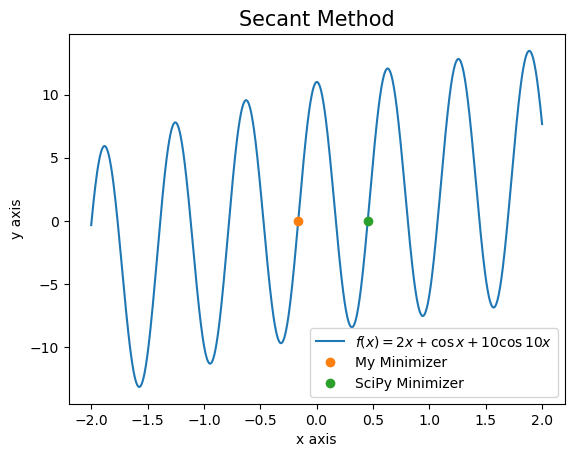

In [59]:
df = lambda x: 2*x + np.cos(x) + 10*np.cos(10*x)

my = secant1d(df, 0, -1)
sci = newton(df, x0=0, tol=1e-10, maxiter=500)

print("my secant minimizer: ", my[0])
print("scipy secant minimizer: ", sci)

plot((-2,2), df,
    [my[0], df(my[0])],
    [sci, df(sci)],
    "My Minimizer", "SciPy Minimizer",
    "Secant Method", "$f(x) = 2x + \cos{x} + 10\cos{10x}$")

## Descent Methods

Backtracking Line Search is a method used in optimization algorithms to determine the step size in the direction of the negative gradient. The idea is to move along the direction of the negative gradient by a certain step size, and then adjust the step size if the objective function does not decrease sufficiently.

The algorithm works as follows:

1. Initialize the step size, alpha, to a large value, and the reduction rate, beta, to a value between 0 and 1.
2. Evaluate the objective function at the new point obtained by moving along the direction of the negative gradient by the step size alpha.
3. If the objective function has decreased sufficiently, return the step size alpha.
4. If the objective function has not decreased sufficiently, reduce the step size by multiplying it by the reduction rate beta, and repeat from step 2.

The backtracking line search algorithm is commonly used in optimization algorithms such as gradient descent, conjugate gradient, and quasi-Newton methods, as it helps ensure that the objective function decreases at each iteration, and that the algorithm converges to the minimum. It is also a useful method for controlling the step size in problems where the function is not smooth, or the gradient is not well-behaved.

The Armijo–Goldstein conditions are used in this optimization algorithm to ensure that the objective function decreases at each iteration and that the algorithm converges to the minimum. They provide a way to control the step size in problems where the function is not smooth, or the gradient is not well-behaved, and help ensure that the algorithm makes progress towards the minimum.The Armijo–Goldstein conditions state that the step size, alpha, should satisfy the following inequality:

$$f(x + \alpha d) \leq f(x) + c \alpha \nabla f(x)^T d$$

where $x$ is the current point, $f(x)$ is the objective function, $\nabla f(x)$ is the gradient of the function, $d$ is the search direction, and $c$ is a positive constant between 0 and 1. The constant $c$ determines the amount of decrease required in the objective function for a given step size.

In [61]:
def backtracking(f, Df, x, p, alpha=1, rho=.9, c=1e-4):
    """Implement the backtracking line search to find a step size that
    satisfies the Armijo condition.

    Parameters:
        f (function): A function f:R^n->R.
        Df (function): The first derivative (gradient) of f.
        x (float): The current approximation to the minimizer.
        p (float): The current search direction.
        alpha (float): A large initial step length.
        rho (float): Parameter in (0, 1).
        c (float): Parameter in (0, 1).

    Returns:
        alpha (float): Optimal step size.
    """
    dfx = Df(x)

    Dfp = dfx.T @ p
    fx = f(x)

    while f(x + alpha*p) > (fx + c * alpha * Dfp):
        alpha = rho * alpha

    return alpha

I test my function against *scipy.optimize.linesearch.scalar_search_armijo()* that finds an acceptable step size using the Armijo rule. It may not give the exact answer as my implementation since it decreases $\alpha$ differently, but the answers should be similar.

In [63]:
# Define functions to minimize
f = lambda x: x[0]**2 + x[1]**2 + x[2]**2
Df = lambda x: np.array([2*x[0], 2*x[1], 2*x[2]])

f = lambda x: x[0]**2 + x[1]**2 + x[2]**2
x = jnp.array([150., .03, 40.]) # Current minimizer guesss.
p = jnp.array([-.5, -100., -4.5]) # Current search direction.
phi = lambda alpha: f(x + alpha*p) # Define phi(alpha).
dphi = grad(phi)

# Perform the backtracking line search
alpha, _ = linesearch.scalar_search_armijo(phi, phi(0.), dphi(0.))
my_alpha = backtracking(f, Df, x, p)

print("my alpha: ", my_alpha)
print("scipy alpha: ", alpha)


my alpha:  0.04710128697246249
scipy alpha:  0.02574722
